# Projeto Data Mining II - Colorectal Cancer

## 1: Import libraries and data

In [526]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk
import graphviz

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import RFE, VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.linear_model import LogisticRegression, LassoCV
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier, BallTree, NearestNeighbors
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
%matplotlib inline


In [527]:
# This script downloads a CSV file from a given URL and loads it into a pandas DataFrame.
url = "https://raw.githubusercontent.com/rgerc8/dm2-class-cancer/9bc81e82c839d3a4b14415d5bbd448452adad0f8/DM2%20Project%20Datasets/patient_train_data.csv"
df_original = pd.read_csv(url)
df = df_original.copy()

## 2: Exploratory Data Analysis (EDA)

In [528]:
#df.shape #(75035, 32)
#df.head(5)
#df.tail(5)
#df.describe().T
#df.describe(include = ['O']).T
#df.info()
#df.columns
#df.isna().sum()

In [529]:
index = ['Alcohol Consumption', 'Cancer Stage', 'Country', 'Date of Birth',
       'Diabetes', 'Diabetes History', 'Diet Risk', 'Early Detection',
       'Family History', 'Gender', 'Genetic Mutation', 'Healthcare Access',
       'Healthcare Costs', 'Heart Disease History', 'Hypertension',
       'Incidence Rate per 100K', 'Inflammatory Bowel Disease',
       'Insurance Costs', 'Insurance Status', 'Marital Status',
       'Mortality Rate per 100K', 'Non Smoker', 'Obesity BMI',
       'Physical Activity', 'Screening History', 'Smoking History',
       'Transfusion History', 'Treatment Type', 'Tumor Size (mm)',
       'Urban or Rural', 'Survival Prediction']

for i in index:
    print('#-----------------------------------#')
    print(df[i].unique())
    print(df[i].value_counts())
    print(df[i].isna().sum())

#-----------------------------------#
['No' 'Yes' nan]
Alcohol Consumption
No     37510
Yes    37473
Name: count, dtype: int64
52
#-----------------------------------#
['Localized' 'Regional' 'Metastatic' nan]
Cancer Stage
Regional      29882
Localized     29820
Metastatic    15320
Name: count, dtype: int64
13
#-----------------------------------#
['UK' 'Japan' 'France' 'USA' 'China' 'South Korea' 'Brazil' 'Germany'
 'Canada' 'Pakistan' 'Italy' 'New Zealand' 'South Africa' 'India'
 'Nigeria' 'Australia' nan]
Country
USA             11627
China            7885
Japan            6378
South Korea      6289
Germany          5507
UK               5472
India            4687
France           4685
Brazil           4594
Canada           3971
Italy            3936
Australia        3012
South Africa     2341
Nigeria          1566
Pakistan         1553
New Zealand      1482
Name: count, dtype: int64
50
#-----------------------------------#
['29-01-1966' '21-12-1958' '16-06-1959' ... '14-02-1992' '1

In [530]:
df['Gender']= df['Gender'].replace('P', np.nan)
df['Healthcare Access']= df['Healthcare Access'].replace('?', np.nan)
df['Urban or Rural']= df['Urban or Rural'].replace('urban', 'Urban')
df['Urban or Rural']= df['Urban or Rural'].replace('rural', 'Rural')
df.drop(columns=['ID', 'Marital Status', 'Transfusion History'], inplace=True)

df_no_na = df.dropna()
print("The number of rows in the original insurance dataset is", df.shape[0])
print("The number of rows in the insurance dataset with no missing values is", df_no_na.shape[0])
print("There were", df.shape[0]-df_no_na.shape[0], "rows containing missing values.")
print("The percentage of rows kept is", df_no_na.shape[0]/df.shape[0] * 100, "%.")

The number of rows in the original insurance dataset is 75035
The number of rows in the insurance dataset with no missing values is 73902
There were 1133 rows containing missing values.
The percentage of rows kept is 98.49003798227494 %.


In [531]:
for i in df_no_na.columns:
    print('#-----------------------------------#')
    print(df_no_na[i].unique())
    print(df_no_na[i].value_counts())
    print(df_no_na[i].isna().sum())

#-----------------------------------#
['No' 'Yes']
Alcohol Consumption
No     36977
Yes    36925
Name: count, dtype: int64
0
#-----------------------------------#
['Localized' 'Regional' 'Metastatic']
Cancer Stage
Regional      29428
Localized     29368
Metastatic    15106
Name: count, dtype: int64
0
#-----------------------------------#
['UK' 'Japan' 'France' 'USA' 'China' 'South Korea' 'Brazil' 'Germany'
 'Canada' 'Pakistan' 'Italy' 'New Zealand' 'South Africa' 'India'
 'Nigeria' 'Australia']
Country
USA             11483
China            7774
Japan            6300
South Korea      6196
Germany          5422
UK               5373
France           4628
India            4606
Brazil           4537
Canada           3920
Italy            3871
Australia        2972
South Africa     2308
Nigeria          1533
Pakistan         1523
New Zealand      1456
Name: count, dtype: int64
0
#-----------------------------------#
['29-01-1966' '21-12-1958' '16-06-1959' ... '14-02-1992' '11-07-1978'
 '16

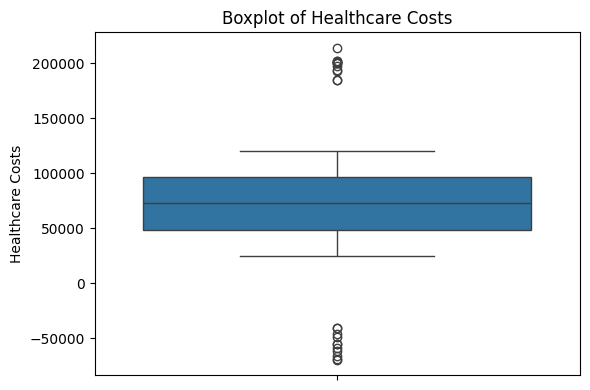

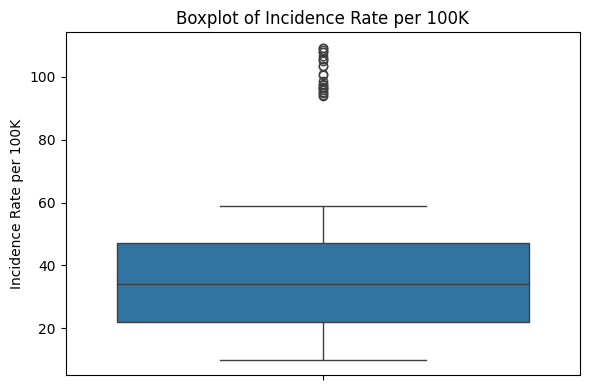

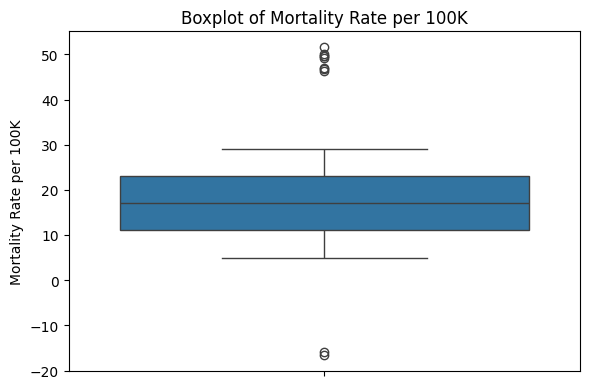

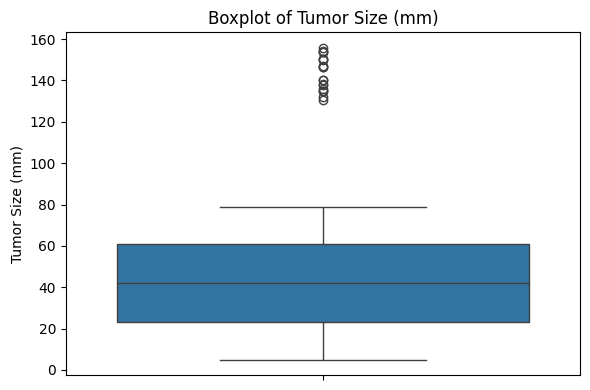

In [532]:
df_no_na_num = df_no_na.select_dtypes(include='number')

for column in df_no_na_num.columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=df_no_na_num[column])
    plt.title(f'Boxplot of {column}')
    plt.tight_layout()
    plt.show()

In [533]:
# Initial shape
print("Original shape:", df_no_na.shape)

# Define filtering rules (based on visual inspection)
df_cleaned = df_no_na[
    (df_no_na['Tumor Size (mm)'] >= 0) & (df_no_na['Tumor Size (mm)'] <= 120) &
    (df_no_na['Mortality Rate per 100K'] >= 0) & (df_no_na['Mortality Rate per 100K'] <= 40) &
    (df_no_na['Incidence Rate per 100K'] >= 0) & (df_no_na['Incidence Rate per 100K'] <= 80) &
    (df_no_na['Healthcare Costs'] >= 0) & (df_no_na['Healthcare Costs'] <= 150000)
]

# Shape after cleaning
print("Cleaned shape:", df_cleaned.shape)

Original shape: (73902, 29)
Cleaned shape: (73826, 29)


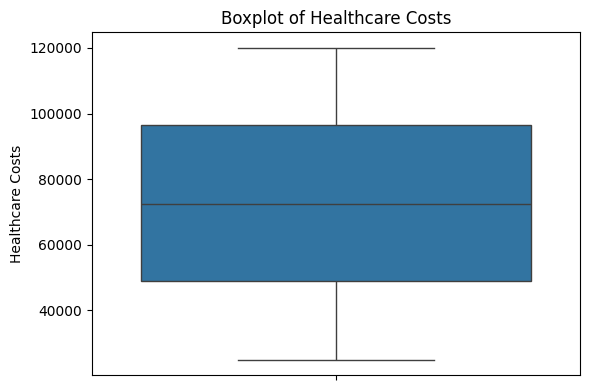

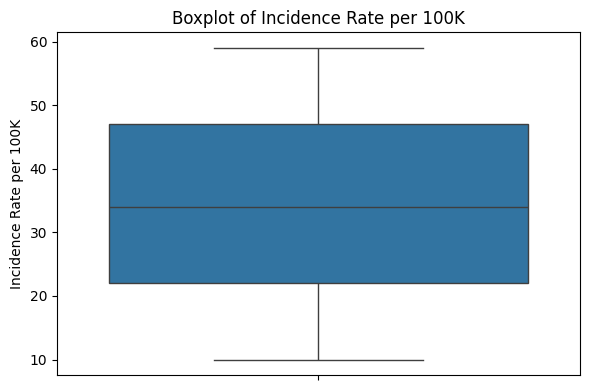

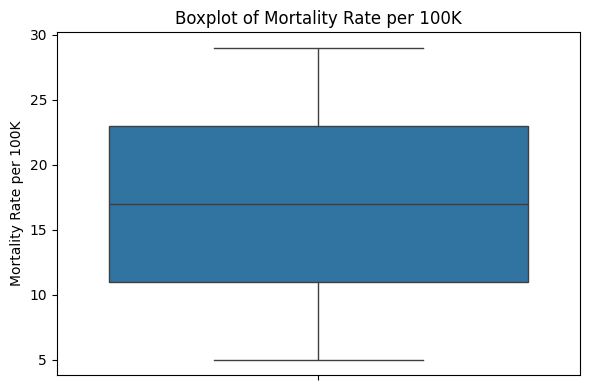

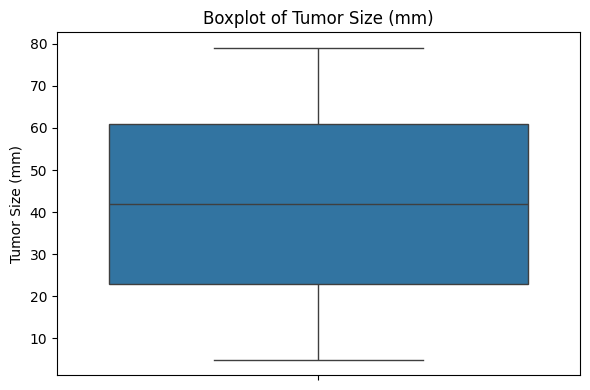

In [534]:
for column in df_cleaned.select_dtypes(include='number').columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=df_cleaned[column])
    plt.title(f'Boxplot of {column}')
    plt.tight_layout()
    plt.show()

/var/folders/1p/kt3x4cqj2j38r8f2_d9w8h9c0000gn/T/ipykernel_25177/1710627193.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Tumor Size Bin'] = pd.cut(df_cleaned['Tumor Size (mm)'], bins=[0, 20, 40, 60, 80, 100], labels=['0–20', '21–40', '41–60', '61–80', '81–100'])


<Axes: xlabel='Tumor Size Bin', ylabel='count'>

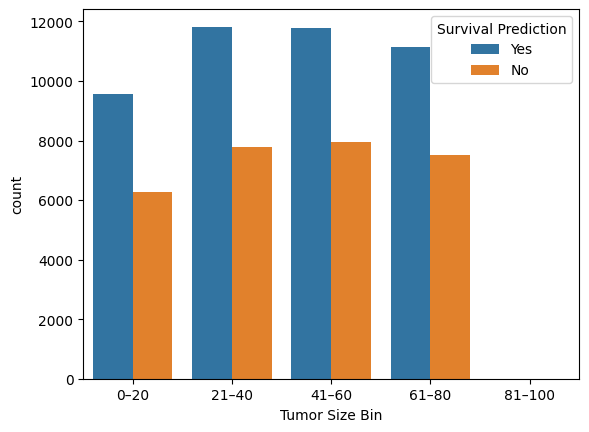

In [535]:
df_cleaned['Tumor Size Bin'] = pd.cut(df_cleaned['Tumor Size (mm)'], bins=[0, 20, 40, 60, 80, 100], labels=['0–20', '21–40', '41–60', '61–80', '81–100'])
sns.countplot(x='Tumor Size Bin', hue='Survival Prediction', data=df_cleaned)

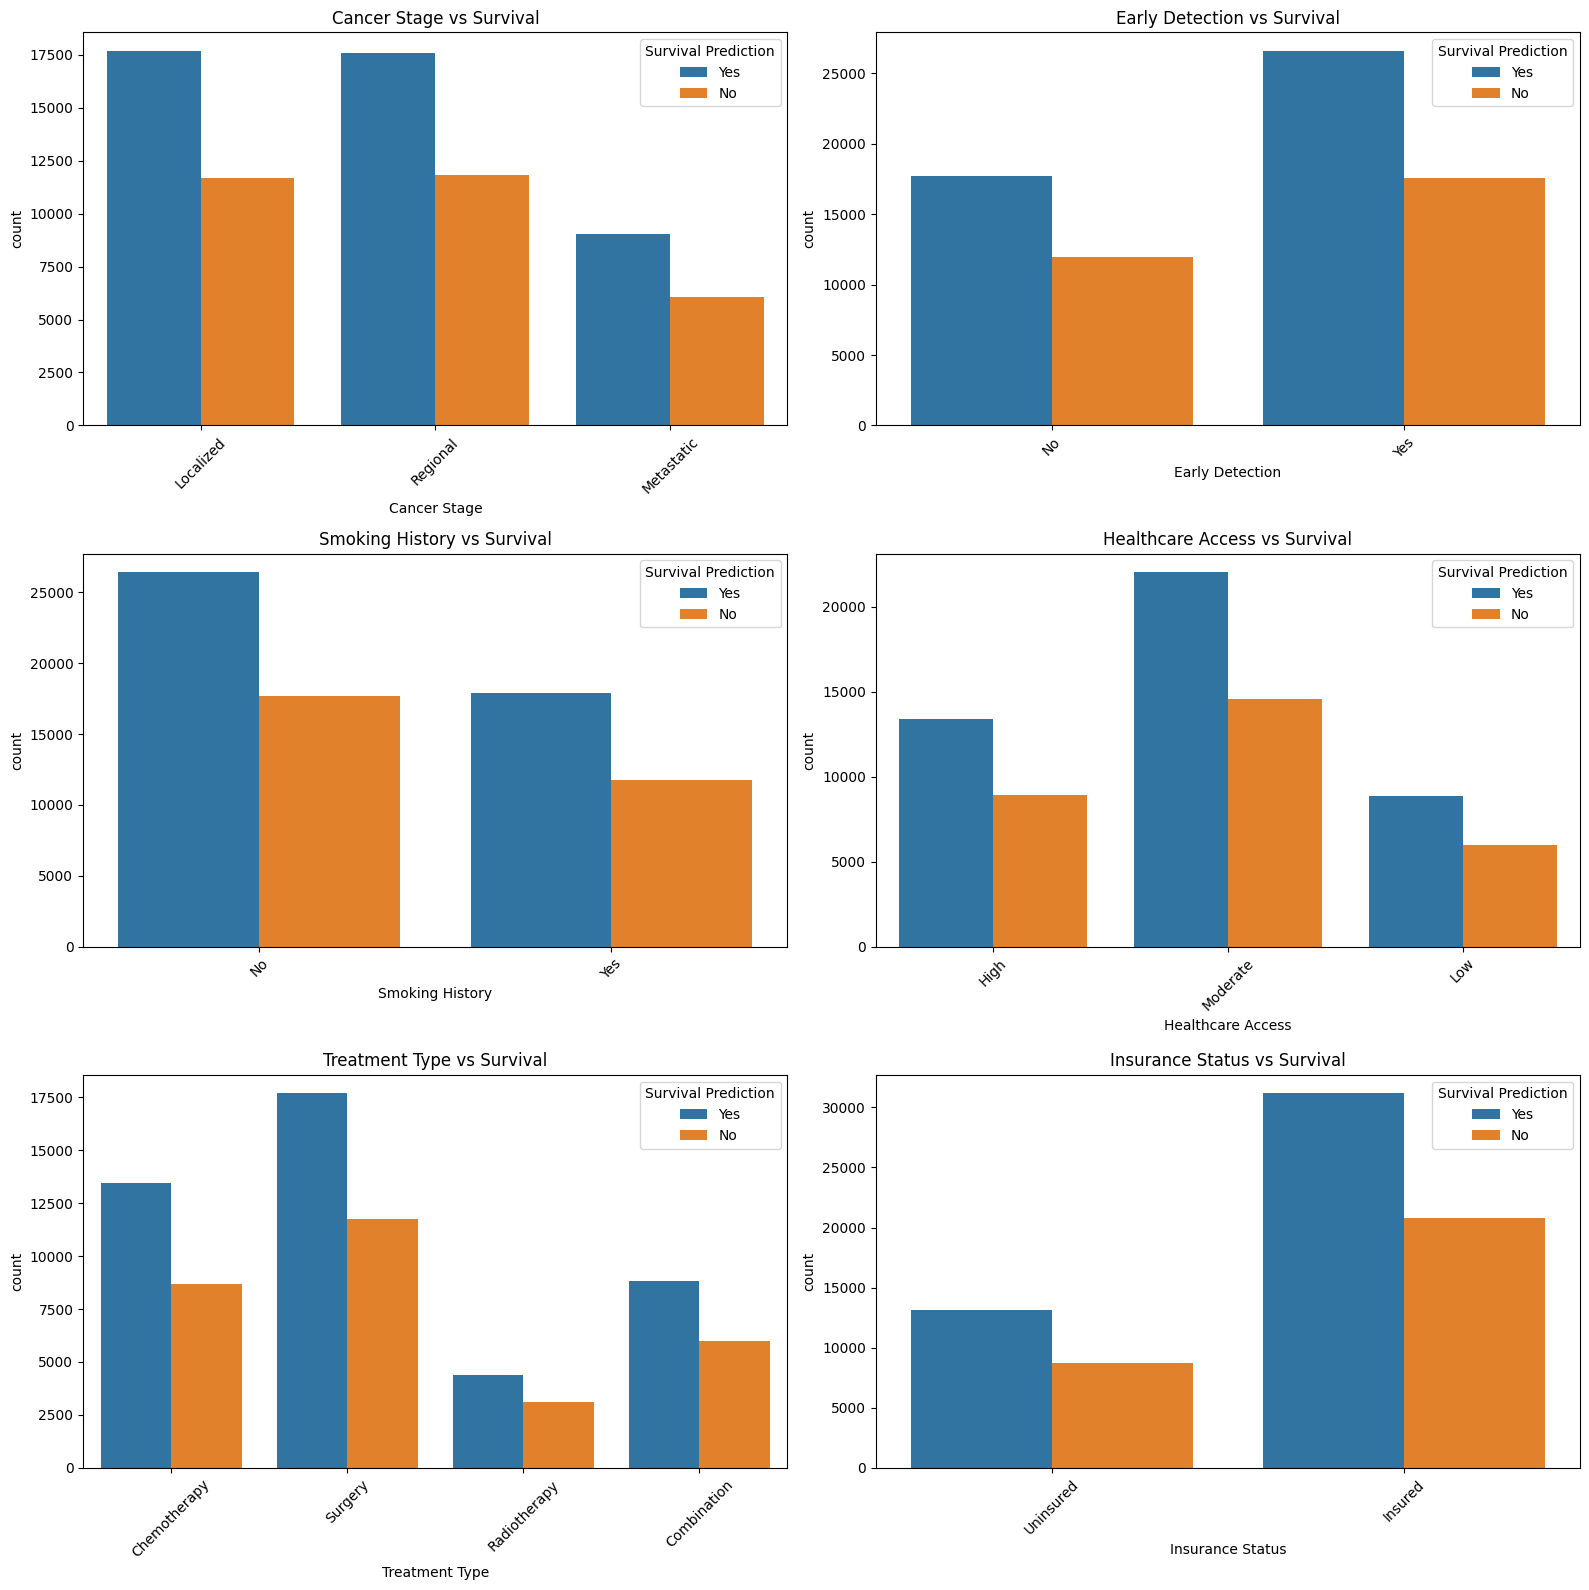

In [536]:
#Set up the figure
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 16))
axes = axes.flatten()

# Plot 1: Cancer Stage vs Survival
sns.countplot(x='Cancer Stage', hue='Survival Prediction', data=df_cleaned, ax=axes[0])
axes[0].set_title('Cancer Stage vs Survival')
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Early Detection vs Survival
sns.countplot(x='Early Detection', hue='Survival Prediction', data=df_cleaned, ax=axes[1])
axes[1].set_title('Early Detection vs Survival')
axes[1].tick_params(axis='x', rotation=45)

# Plot 3: Smoking History vs Survival
sns.countplot(x='Smoking History', hue='Survival Prediction', data=df_cleaned, ax=axes[2])
axes[2].set_title('Smoking History vs Survival')
axes[2].tick_params(axis='x', rotation=45)

# Plot 4: Healthcare Access vs Survival
sns.countplot(x='Healthcare Access', hue='Survival Prediction', data=df_cleaned, ax=axes[3])
axes[3].set_title('Healthcare Access vs Survival')
axes[3].tick_params(axis='x', rotation=45)

# Plot 5: Treatment Type vs Survival
sns.countplot(x='Treatment Type', hue='Survival Prediction', data=df_cleaned, ax=axes[4])
axes[4].set_title('Treatment Type vs Survival')
axes[4].tick_params(axis='x', rotation=45)

# Plot 6: Insurance Status vs Survival
sns.countplot(x='Insurance Status', hue='Survival Prediction', data=df_cleaned, ax=axes[5])
axes[5].set_title('Insurance Status vs Survival')
axes[5].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


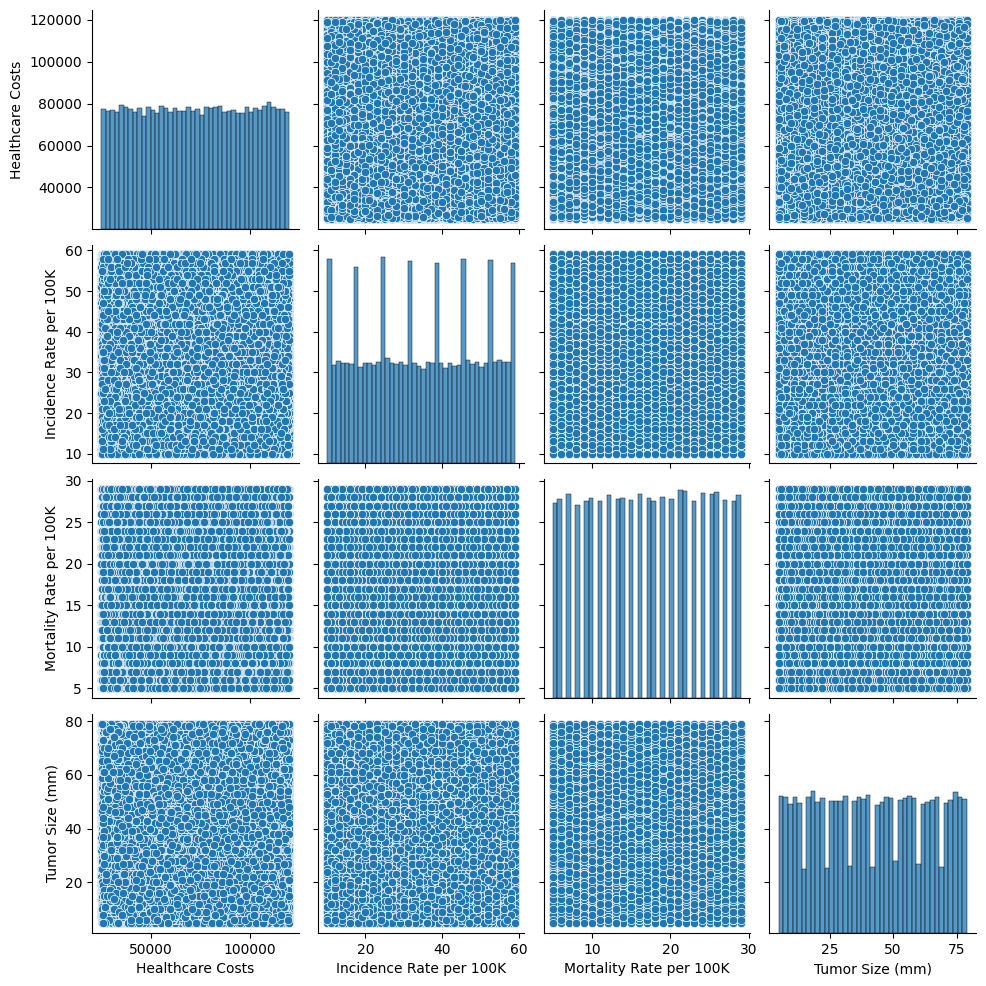

In [537]:
sns.pairplot(data = df_cleaned.select_dtypes(include='number'))

<Axes: xlabel='Survival Prediction', ylabel='count'>

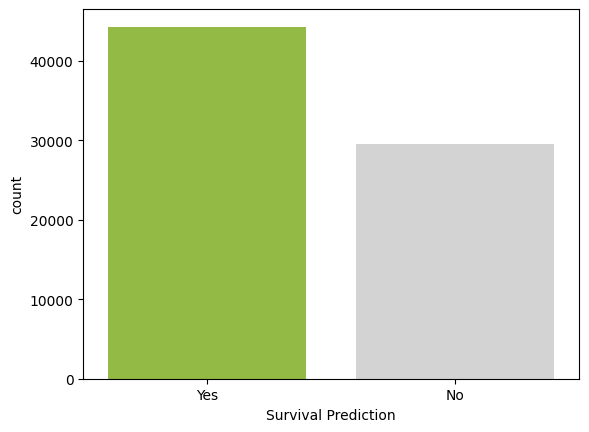

In [538]:
sns.countplot(x='Survival Prediction', data=df_cleaned, hue='Survival Prediction', palette=["yellowgreen","lightgrey"], legend=False)

In [539]:
df_cleaned.skew(numeric_only=True)

Healthcare Costs          -0.002652
Incidence Rate per 100K   -0.001064
Mortality Rate per 100K   -0.011837
Tumor Size (mm)           -0.000633
dtype: float64

In [540]:
df_cleaned.kurtosis(numeric_only=True)

Healthcare Costs          -1.203461
Incidence Rate per 100K   -1.204756
Mortality Rate per 100K   -1.202469
Tumor Size (mm)           -1.200659
dtype: float64

<Axes: >

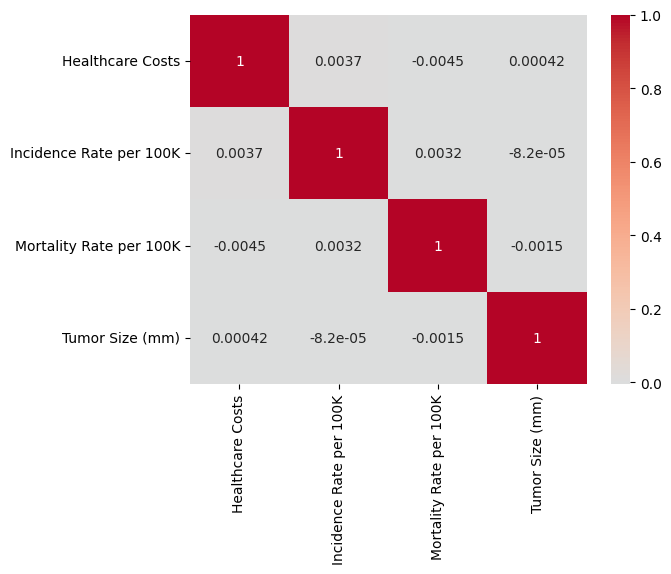

In [541]:
sns.heatmap(df_cleaned.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm', center=0)


In [542]:
pd.crosstab(df_cleaned["Cancer Stage"], df_cleaned["Diabetes History"], margins=True)
df_cleaned["Cancer Stage"].value_counts()
df_cleaned["Diabetes History"].value_counts()

Diabetes History
No     73816
Yes       10
Name: count, dtype: int64

## 3: Data Preprocessing

In [543]:
df_cleaned['Date of Birth'].min(), df_cleaned['Date of Birth'].max() # ('01-01-1936', '31-12-1992')

df_cleaned['Date of Birth'] = pd.to_datetime(df_cleaned['Date of Birth'])
df_cleaned['Age'] = datetime.now().year - df_cleaned['Date of Birth'].dt.year

yes_no_cols = ['Alcohol Consumption', 'Diabetes', 'Diabetes History', 'Early Detection', 'Family History', 
               'Genetic Mutation','Heart Disease History','Hypertension', 'Inflammatory Bowel Disease', 'Smoking History',
               'Survival Prediction']

for col in yes_no_cols:
    df_cleaned[col] = df_cleaned[col].map({'Yes': 1, 'No': 0}).astype(int)
    
df_cleaned['Gender'] = df_cleaned['Gender'].map({'F': 0, 'M': 1}).astype(int)
df_cleaned['Insurance Status'] = df_cleaned['Insurance Status'].map({'Uninsured': 0, 'Insured': 1}).astype(int)
df_cleaned['Urban or Rural'] = df_cleaned['Urban or Rural'].map({'Urban': 1, 'Rural': 0}).astype(int)

df_cleaned['Non Smoker'] = df_cleaned['Non Smoker'].map({'Yes': 0, 'No': 1}).astype(int) # Diferente por causa do Lifestyle Risk
df_cleaned['Obesity BMI'] = df_cleaned['Obesity BMI'].map({'Normal': 0, 'Overweight': 1, 'Obese': 2}).astype(int) # ORDINAL
df_cleaned['Physical Activity'] = df_cleaned['Physical Activity'].map({'Low': 2, 'Moderate': 1, 'High': 0}).astype(int)  # ORDINAL # Diferente por causa do Lifestyle Risk
df_cleaned['Diet Risk'] = df_cleaned['Diet Risk'].map({'Low': 0, 'Moderate': 1, 'High': 2}).astype(int) # ORDINAL

#df_cleaned['Lifestyle Risk'] = (df_cleaned['Obesity BMI'] + df_cleaned['Diet Risk'] + df_cleaned['Physical Activity'] + df_cleaned['Non Smoker'])

ordinal_cols = [
    'Cancer Stage', 'Diet Risk', 'Healthcare Access', 'Insurance Costs',
    'Obesity BMI', 'Physical Activity', 'Screening History', 'Treatment Type'
]

# Convert ordinal features to one-hot
df_cleaned = pd.get_dummies(df_cleaned, columns=ordinal_cols, prefix=ordinal_cols, drop_first=False, dtype=int)

# Convert categorical features to one-hot encoding
df_cleaned = pd.get_dummies(df_cleaned, columns=['Country'], prefix='Country', drop_first=False, dtype=int)

df_cleaned.drop(columns=['Date of Birth', 'Tumor Size Bin'], inplace=True)

df_cleaned = df_cleaned[[c for c in df_cleaned.columns if c != 'Survival Prediction'] + ['Survival Prediction']]

/var/folders/1p/kt3x4cqj2j38r8f2_d9w8h9c0000gn/T/ipykernel_25177/4050237739.py:3: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_cleaned['Date of Birth'] = pd.to_datetime(df_cleaned['Date of Birth'])
/var/folders/1p/kt3x4cqj2j38r8f2_d9w8h9c0000gn/T/ipykernel_25177/4050237739.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Date of Birth'] = pd.to_datetime(df_cleaned['Date of Birth'])
/var/folders/1p/kt3x4cqj2j38r8f2_d9w8h9c0000gn/T/ipykernel_25177/4050237739.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [544]:
# Check skewness of numerical features
print(df_cleaned['Healthcare Costs'].skew())
print(df_cleaned['Mortality Rate per 100K'].skew())
print(df_cleaned['Incidence Rate per 100K'].skew())
print(df_cleaned['Tumor Size (mm)'].skew())

-0.0026520702610085822
-0.011837301244940127
-0.0010644983510826405
-0.0006328004341507583


In [545]:
# Create X and y variables
X = df_cleaned.drop('Survival Prediction', axis = 1)
y = df_cleaned['Survival Prediction']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20,
                                                    stratify = y,
                                                    random_state=5)

num_cols = ['Healthcare Costs', 'Incidence Rate per 100K', 'Mortality Rate per 100K', 'Tumor Size (mm)', 'Age']

# Initialize and fit scaler on training data only
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])

# Apply the same scaler to the test data (without re-fitting)
X_test[num_cols] = scaler.transform(X_test[num_cols])

## 4: Feature Selection

### 4.1: RFE

In [546]:
# RFE with LogisticRegression
estimator1 = LogisticRegression(max_iter=1000, random_state=5, penalty='l2', solver='liblinear')

# Select top 10 features (adjust n_features_to_select as needed)
rfe1 = RFE(estimator1, n_features_to_select=20)  
X_rfe = rfe1.fit_transform(X = X_train, y = y_train)

#rfe.support_
#rfe.ranking_

# Get selected features
selected_features1 = X_train.columns[rfe1.support_]
print("Selected Features:", list(selected_features1))

X_train_rfe = X_train[selected_features1]
X_test_rfe = X_test[selected_features1]

Selected Features: ['Diabetes History', 'Cancer Stage_Localized', 'Cancer Stage_Metastatic', 'Cancer Stage_Regional', 'Diet Risk_0', 'Diet Risk_1', 'Diet Risk_2', 'Healthcare Access_High', 'Healthcare Access_Low', 'Healthcare Access_Moderate', 'Insurance Costs_Basic', 'Obesity BMI_0', 'Obesity BMI_1', 'Obesity BMI_2', 'Treatment Type_Chemotherapy', 'Treatment Type_Combination', 'Treatment Type_Surgery', 'Country_Australia', 'Country_Italy', 'Country_Pakistan']


In [547]:
'''
##### penalty='l1', solver='saga', n_features_to_select=10 #####
Selected Features: ['Diabetes History', 'Treatment Type_Chemotherapy', 'Treatment Type_Radiotherapy', 
                    'Country_Australia', 'Country_Brazil', 'Country_Canada', 'Country_France', 
                    'Country_Italy', 'Country_Nigeria', 'Country_Pakistan']

##### penalty='l1', solver='saga', n_features_to_select=15 #####
Selected Features: ['Diabetes History', 'Treatment Type_Chemotherapy', 'Treatment Type_Radiotherapy', 
                    'Country_Australia', 'Country_Brazil', 'Country_Canada', 'Country_France', 
                    'Country_Italy', 'Country_Japan', 'Country_New Zealand', 'Country_Nigeria', 
                    'Country_Pakistan', 'Country_South Korea', 'Country_UK', 'Country_USA']
                    
##### penalty='l1', solver='saga', n_features_to_select=20 #####
Selected Features: ['Diabetes History', 'Family History', 'Insurance Status', 'Smoking History', 
                    'Physical Activity_0', 'Screening History_Irregular', 'Treatment Type_Chemotherapy', 
                    'Treatment Type_Radiotherapy', 'Country_Australia', 'Country_Brazil', 'Country_Canada', 
                    'Country_France', 'Country_Italy', 'Country_Japan', 'Country_New Zealand', 'Country_Nigeria', 
                    'Country_Pakistan', 'Country_South Korea', 'Country_UK', 'Country_USA']

##### penalty='l1', solver='liblinear', n_features_to_select=10 #####
Selected Features: ['Diabetes History', 'Treatment Type_Chemotherapy', 'Treatment Type_Radiotherapy', 
                    'Country_Australia', 'Country_Brazil', 'Country_Canada', 'Country_France', 'Country_Italy', 
                    'Country_Nigeria', 'Country_Pakistan']

##### penalty='l1', solver='liblinear', n_features_to_select=15 #####
Selected Features: ['Diabetes History', 'Treatment Type_Chemotherapy', 'Treatment Type_Radiotherapy', 'Country_Australia', 
                    'Country_Brazil', 'Country_Canada', 'Country_France', 'Country_Italy', 'Country_Japan', 'Country_New Zealand', 
                    'Country_Nigeria', 'Country_Pakistan', 'Country_South Korea', 'Country_UK', 'Country_USA']

##### penalty='l1', solver='liblinear', n_features_to_select=20 #####
Selected Features: ['Diabetes History', 'Family History', 'Healthcare Costs', 'Insurance Status', 'Tumor Size (mm)', 
                    'Screening History_Irregular', 'Treatment Type_Chemotherapy', 'Treatment Type_Radiotherapy', 
                    'Country_Australia', 'Country_Brazil', 'Country_Canada', 'Country_France', 'Country_Italy', 
                    'Country_Japan', 'Country_New Zealand', 'Country_Nigeria', 'Country_Pakistan', 'Country_South Korea', 
                    'Country_UK', 'Country_USA']

##### penalty='l2', solver='liblinear', n_features_to_select=10 #####
Selected Features: ['Diabetes History', 'Cancer Stage_Localized', 'Cancer Stage_Metastatic', 'Cancer Stage_Regional', 
                    'Healthcare Access_High', 'Healthcare Access_Low', 'Healthcare Access_Moderate', 'Country_Australia', 
                    'Country_Italy', 'Country_Pakistan']

##### penalty='l2', solver='liblinear', n_features_to_select=15 #####
Selected Features: ['Diabetes History', 'Cancer Stage_Localized', 'Cancer Stage_Metastatic', 'Cancer Stage_Regional', 
                    'Diet Risk_0', 'Diet Risk_1', 'Diet Risk_2', 'Healthcare Access_High', 'Healthcare Access_Low', 
                    'Healthcare Access_Moderate', 'Treatment Type_Chemotherapy', 'Treatment Type_Surgery', 'Country_Australia', 
                    'Country_Italy', 'Country_Pakistan']

##### penalty='l2', solver='liblinear', n_features_to_select=20 #####
Selected Features: ['Diabetes History', 'Cancer Stage_Localized', 'Cancer Stage_Metastatic', 'Cancer Stage_Regional', 
                    'Diet Risk_0', 'Diet Risk_1', 'Diet Risk_2', 'Healthcare Access_High', 'Healthcare Access_Low', 
                    'Healthcare Access_Moderate', 'Insurance Costs_Basic', 'Insurance Costs_Extended', 'Insurance Costs_No insurance', 
                    'Treatment Type_Chemotherapy', 'Treatment Type_Combination', 'Treatment Type_Surgery', 'Country_Australia', 
                    'Country_Canada', 'Country_Italy', 'Country_Pakistan']

##### penalty='l2', solver='lbfgs', n_features_to_select=10 #####
Selected Features: ['Cancer Stage_Localized', 'Cancer Stage_Metastatic', 'Cancer Stage_Regional', 'Healthcare Access_High', 
                    'Healthcare Access_Low', 'Healthcare Access_Moderate', 'Insurance Costs_Basic', 'Country_Australia', 
                    'Country_Italy', 'Country_Pakistan']

##### penalty='l2', solver='lbfgs', n_features_to_select=15 #####
Selected Features: ['Cancer Stage_Localized', 'Cancer Stage_Metastatic', 'Cancer Stage_Regional', 'Healthcare Access_High', 
                    'Healthcare Access_Low', 'Healthcare Access_Moderate', 'Insurance Costs_Basic', 'Insurance Costs_Extended', 
                    'Insurance Costs_No insurance', 'Treatment Type_Chemotherapy', 'Treatment Type_Combination', 'Treatment Type_Surgery', 
                    'Country_Australia', 'Country_Italy', 'Country_Pakistan']

##### penalty='l2', solver='lbfgs', n_features_to_select=20 #####
Selected Features: ['Cancer Stage_Localized', 'Cancer Stage_Metastatic', 'Cancer Stage_Regional', 'Healthcare Access_High', 
                    'Healthcare Access_Low', 'Healthcare Access_Moderate', 'Insurance Costs_Basic', 'Insurance Costs_Extended', 
                    'Insurance Costs_No insurance', 'Treatment Type_Chemotherapy', 'Treatment Type_Combination', 'Treatment Type_Surgery', 
                    'Country_Australia', 'Country_Brazil', 'Country_Canada', 'Country_France', 'Country_Italy', 'Country_Japan', 
                    'Country_Nigeria', 'Country_Pakistan']
'''

"\n##### penalty='l1', solver='saga', n_features_to_select=10 #####\nSelected Features: ['Diabetes History', 'Treatment Type_Chemotherapy', 'Treatment Type_Radiotherapy', \n                    'Country_Australia', 'Country_Brazil', 'Country_Canada', 'Country_France', \n                    'Country_Italy', 'Country_Nigeria', 'Country_Pakistan']\n\n##### penalty='l1', solver='saga', n_features_to_select=15 #####\nSelected Features: ['Diabetes History', 'Treatment Type_Chemotherapy', 'Treatment Type_Radiotherapy', \n                    'Country_Australia', 'Country_Brazil', 'Country_Canada', 'Country_France', \n                    'Country_Italy', 'Country_Japan', 'Country_New Zealand', 'Country_Nigeria', \n                    'Country_Pakistan', 'Country_South Korea', 'Country_UK', 'Country_USA']\n\n##### penalty='l1', solver='saga', n_features_to_select=20 #####\nSelected Features: ['Diabetes History', 'Family History', 'Insurance Status', 'Smoking History', \n                    'Physi

### 4.2: Random Forest

In [397]:
# Initialize the Random Forest classifier
estimator2 = RandomForestClassifier(n_estimators=100, random_state=5)

# RFE wrapper to select top N features
rfe2 = RFE(estimator2, n_features_to_select=20)  # Change 20 to the number of features you want

# Fit RFE on training data
X_rfc = rfe2.fit_transform(X_train, y_train)

# Get the selected feature names
selected_features2 = X_train.columns[rfe2.support_]
print("Selected Features:", list(selected_features2))

# Feature ranking: 1 = selected, higher = less important
ranking = pd.Series(rfe2.ranking_, index=X_train.columns).sort_values()
print("\nTop Ranked Features:\n", ranking.head(30))

X_train_rfc = X_train[selected_features2]
X_test_rfc = X_test[selected_features2]

Selected Features: ['Alcohol Consumption', 'Early Detection', 'Family History', 'Gender', 'Healthcare Costs', 'Incidence Rate per 100K', 'Insurance Status', 'Mortality Rate per 100K', 'Smoking History', 'Tumor Size (mm)', 'Urban or Rural', 'Age', 'Lifestyle Risk', 'Cancer Stage_Regional', 'Diet Risk_1', 'Healthcare Access_Moderate', 'Insurance Costs_No insurance', 'Physical Activity_1', 'Screening History_Regular', 'Treatment Type_Surgery']

Top Ranked Features:
 Alcohol Consumption              1
Early Detection                  1
Gender                           1
Family History                   1
Healthcare Costs                 1
Mortality Rate per 100K          1
Smoking History                  1
Incidence Rate per 100K          1
Insurance Status                 1
Healthcare Access_Moderate       1
Insurance Costs_No insurance     1
Cancer Stage_Regional            1
Lifestyle Risk                   1
Age                              1
Urban or Rural                   1
Tumor S

### 4.3: Mutual Information

In [548]:
# Mutual Information Classifier
mi_scores = mutual_info_classif(X_train, y_train, random_state=42)
mi_df = pd.DataFrame({'Feature': X_train.columns, 'MI_Score': mi_scores})
mi_df.sort_values('MI_Score', ascending=False, inplace=True)
print(mi_df.head())

# Select top 10 features by mutual information score
top_features = mi_df['Feature'].head(20).tolist()

# Filter X_train and X_test to keep only the top features
X_train_mi = X_train[top_features]
X_test_mi = X_test[top_features]

                       Feature  MI_Score
17              Urban or Rural  0.008528
5                       Gender  0.008114
27  Healthcare Access_Moderate  0.006190
3              Early Detection  0.006077
15             Smoking History  0.005515


## 5: BernoulliNB Classifier

In [213]:
# Initialize BernoulliNB (better for binary/one-hot encoded features)
modelBNB = BernoulliNB(alpha=1.0, class_prior=[0.5, 0.5])  # alpha=1 for Laplace smoothing
modelBNB.fit(X=X_train_mi, y=y_train)

# Predictions
labels_train = modelBNB.predict(X_train_mi)
labels_test = modelBNB.predict(X_test_mi)

# Scores
train_acc = modelBNB.score(X_train_mi, y_train)
test_acc = modelBNB.score(X_test_mi, y_test)
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# F1 Scores
print(f'\nF1 Score (train): {f1_score(y_train, labels_train):.3f}')
print(f'F1 Score (test): {f1_score(y_test, labels_test):.3f}')

# Feature log probabilities (equivalent to theta_ in GaussianNB)
print("\nFeature log probabilities (class 0 vs class 1):")
print(pd.DataFrame(
    data=np.exp(modelBNB.feature_log_prob_),  # Convert from log to probability
    columns=X_train_mi.columns).T)

# Class priors
print("\nClass priors (P(y)):")
print(modelBNB.class_count_ / modelBNB.class_count_.sum())

Train Accuracy: 0.5040
Test Accuracy: 0.4919

F1 Score (train): 0.550
F1 Score (test): 0.539

Feature log probabilities (class 0 vs class 1):
                                    0         1
Urban or Rural               0.699780  0.700575
Non Smoker                   0.398967  0.403380
Diet Risk_1                  0.499026  0.501523
Healthcare Access_Moderate   0.497756  0.499379
Alcohol Consumption          0.499026  0.501608
Physical Activity_2          0.301914  0.304277
Screening History_Irregular  0.397104  0.401348
Insurance Status             0.706343  0.702861
Genetic Mutation             0.149560  0.148527
Heart Disease History        0.100398  0.101557
Country_Pakistan             0.021511  0.019860
Lifestyle Risk               0.990007  0.989308
Obesity BMI_1                0.400703  0.398781
Hypertension                 0.200881  0.202522
Insurance Costs_Basic        0.331978  0.334180
Diabetes                     0.198425  0.200237
Cancer Stage_Localized       0.396553  0.3

In [214]:
from sklearn.metrics import classification_report
print(classification_report(y_test, labels_test))

              precision    recall  f1-score   support

           0       0.39      0.49      0.43      5904
           1       0.59      0.49      0.54      8862

    accuracy                           0.49     14766
   macro avg       0.49      0.49      0.49     14766
weighted avg       0.51      0.49      0.50     14766



## 6: KNN Classifier

In [ ]:
param_grid = {
    'n_neighbors': list(range(2, 30)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
    'algorithm': ['auto', 'brute']
}

modelKNN = KNeighborsClassifier()
grid_search = GridSearchCV(modelKNN, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X = X_train_mi, y = y_train)

labels_train = grid_search.predict(X_train_mi)
labels_test = grid_search.predict(X_test_mi)

print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

print("Train Accuracy:", accuracy_score(y_train, labels_train))
print("Test Accuracy:", accuracy_score(y_test, labels_test))
print("Train F1 Score:", f1_score(y_train, labels_train))
print("Test F1 Score:", f1_score(y_test, labels_test))

# Final model
best_knn = grid_search.best_estimator_
print(best_knn)
'''
Best Parameters: {'algorithm': 'auto', 'n_neighbors': 29, 'p': 1, 'weights': 'uniform'}
Best F1 Score: 0.7090016345148078
Train Accuracy: 0.6140365729766339
Test Accuracy: 0.5716510903426791
Train F1 Score: 0.7364587548413203
Test F1 Score: 0.7078117060100707
KNeighborsClassifier(n_neighbors=29, p=1)
'''

Best Parameters: {'algorithm': 'auto', 'n_neighbors': 29, 'p': 1, 'weights': 'uniform'}
Best F1 Score: 0.7090016345148078
Train Accuracy: 0.6140365729766339
Test Accuracy: 0.5716510903426791
Train F1 Score: 0.7364587548413203
Test F1 Score: 0.7078117060100707
KNeighborsClassifier(n_neighbors=29, p=1)


In [ ]:
precision = precision_score(y_test, labels_test)
recall = recall_score(y_test, labels_test)
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
'''
Precision: 0.599
Recall:    0.864
'''

Precision: 0.599
Recall:    0.864


## 7: Decision Tree

In [311]:
scores_train = []
scores_test = []
parameters = []

for i in range(7, 12):
    for j in range(6,9):
        for p in range(5, 8):
            parameters.append([i,j,p])
            DTR = DecisionTreeClassifier(max_depth=i, min_samples_split=j, min_samples_leaf=p, class_weight='balanced', random_state=5)
            DTR.fit(X_train_mi, y_train)
            scores_train.append(DTR.score(X_train_mi, y_train))
            scores_test.append(DTR.score(X_test_mi, y_test))

In [312]:
len(scores_train)

45

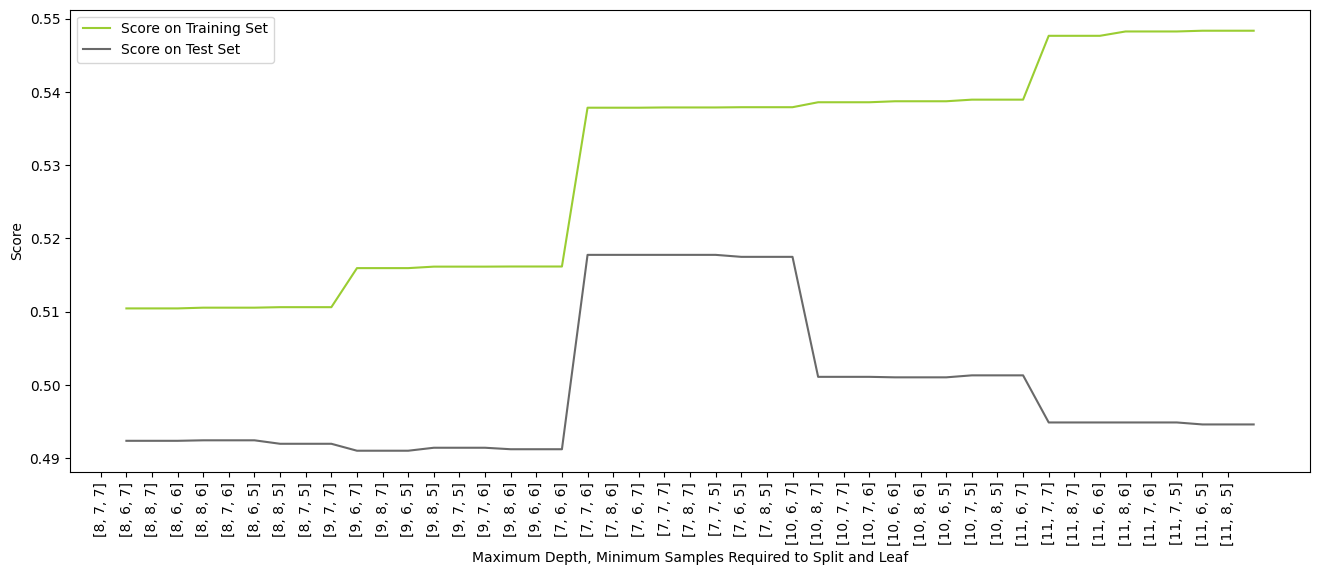

In [313]:
scores = pd.DataFrame({'Score_Train': scores_train,'Score_Test': scores_test,'Parameters': parameters}).sort_values(by=['Score_Train'])
plt.figure(figsize=(16,6))
plt.plot(list(range(1,46)), scores['Score_Train'], label="Score on Training Set", color='yellowgreen')
plt.plot(list(range(1,46)), scores['Score_Test'], label="Score on Test Set", color='dimgray')
plt.xlabel("Maximum Depth, Minimum Samples Required to Split and Leaf")
plt.ylabel("Score")
plt.xticks(np.arange(len(parameters)), scores['Parameters'])
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [337]:
# Define parameter grid for tuning
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 3, 5, 7, 10, 15],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 5, 10],
    'class_weight': [None, 'balanced'],
}

# Initialize and tune the model
modelDT = DecisionTreeClassifier(random_state=5, class_weight='balanced')
grid_search = GridSearchCV(modelDT, param_grid, cv=5, scoring='precision', n_jobs=-1)
grid_search.fit(X=X_train_mi, y=y_train)

# Get predictions
labels_train = grid_search.predict(X_train_mi)
labels_test = grid_search.predict(X_test_mi)

# Print results
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score (CV):", grid_search.best_score_)
print("\nTrain Accuracy:", accuracy_score(y_train, labels_train))
print("Test Accuracy:", accuracy_score(y_test, labels_test))
print("\nTrain F1 Score:", f1_score(y_train, labels_train))
print("Test F1 Score:", f1_score(y_test, labels_test))

# Detailed classification report
print("\nClassification Report (Test):")
print(classification_report(y_test, labels_test))

# Confusion matrix
print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, labels_test))

# Final model
best_dt = grid_search.best_estimator_
print("\nBest Decision Tree Model:")
print(best_dt)

Best Parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 15}
Best F1 Score (CV): 0.6035272481231558

Train Accuracy: 0.6915340331865899
Test Accuracy: 0.5065691453338751

Train F1 Score: 0.7202825118992784
Test F1 Score: 0.5542094958394518

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.41      0.50      0.45      5904
           1       0.61      0.51      0.55      8862

    accuracy                           0.51     14766
   macro avg       0.51      0.51      0.50     14766
weighted avg       0.53      0.51      0.51     14766


Confusion Matrix (Test):
[[2951 2953]
 [4333 4529]]

Best Decision Tree Model:
DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       min_samples_split=15, random_state=5)


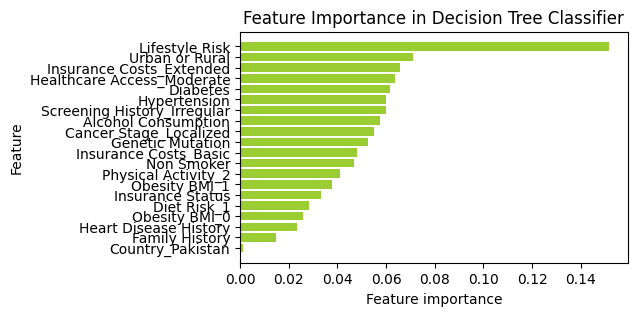

In [285]:
def plot_feature_importances(model, DF):
    # Get feature importances and names
    importances = model.feature_importances_
    feature_names = DF.columns
    
    # Sort features by importance (descending order)
    indices = np.argsort(importances)
    sorted_importances = importances[indices]
    sorted_feature_names = feature_names[indices]
    
    # Plot
    plt.figure(figsize=(5,3))
    plt.barh(range(len(importances)), sorted_importances, color='yellowgreen')
    plt.yticks(np.arange(len(importances)), sorted_feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.title('Feature Importance in Decision Tree Classifier')
    plt.show()
    

plot_feature_importances(grid_search.best_estimator_,X_train_mi)

In [ ]:
modelDT = DecisionTreeClassifier(random_state=5, class_weight='balanced')
modelDT.fit(X_train_mi, y_train)
y_pred = modelDT.predict(X_test_mi)
modelDT.score(X_test_mi, y_test)

0.5056210212650684

In [250]:
modelDT.feature_importances_

array([0.05010097, 0.04913158, 0.0685546 , 0.05488659, 0.07051522,
       0.02345376, 0.0715732 , 0.07443925, 0.01817484, 0.03626516,
       0.01080405, 0.08171427, 0.04527819, 0.04462141, 0.03612214,
       0.05268357, 0.05741019, 0.06447842, 0.05793639, 0.03185623])

## 8: Ensemble Classifiers

### 8.1: Decision Tree with Bagging

In [415]:
original_dt = DecisionTreeClassifier(class_weight='balanced', random_state=5)

bagging_dt = BaggingClassifier(estimator=original_dt, random_state=5, n_jobs=-1, bootstrap=True, oob_score=True)

# Define parameter grid for base estimator (prefix with estimator__)
param_grid_bagg = {
    'estimator__max_depth': [3, 5, 7],
    'estimator__min_samples_leaf': [2, 5, 10],
    'n_estimators': [50, 100, 200],
    'max_samples': [0.6, 0.8, 1.0],
    'max_features': [0.6, 0.8, 1.0]
}

grid_search_bagg = GridSearchCV(bagging_dt, param_grid_bagg, cv=5, scoring='precision', n_jobs=-1)

grid_search_bagg.fit(X=X_train, y=y_train)

# Get predictions
labels_train_bagg = grid_search_bagg.predict(X_train)
labels_test_bagg = grid_search_bagg.predict(X_test)

# Print results
print("Best Parameters:", grid_search_bagg.best_params_)
print("Best F1 Score (CV):", grid_search_bagg.best_score_)
print("\nTrain Accuracy:", accuracy_score(y_train, labels_train_bagg))
print("Test Accuracy:", accuracy_score(y_test, labels_test_bagg))
print("\nTrain F1 Score:", f1_score(y_train, labels_train_bagg))
print("Test F1 Score:", f1_score(y_test, labels_test_bagg))

# Detailed classification report
print("\nClassification Report (Test):")
print(classification_report(y_test, labels_test_bagg))

# Confusion matrix
print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, labels_test_bagg))

# Final model
best_dt_bagg = grid_search.best_estimator_
print("\nBest Decision Tree Model (with Bagging):")
print(best_dt_bagg)

Best Parameters: {'estimator__max_depth': 5, 'estimator__min_samples_leaf': 5, 'max_features': 0.8, 'max_samples': 1.0, 'n_estimators': 50}
Best F1 Score (CV): 0.6053273568275611

Train Accuracy: 0.5574161869285472
Test Accuracy: 0.5046051740484898

Train F1 Score: 0.5970618612322918
Test F1 Score: 0.5493192039923603

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.40      0.51      0.45      5904
           1       0.60      0.50      0.55      8862

    accuracy                           0.50     14766
   macro avg       0.50      0.50      0.50     14766
weighted avg       0.52      0.50      0.51     14766


Confusion Matrix (Test):
[[2993 2911]
 [4404 4458]]

Best Decision Tree Model (with Bagging):
DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       min_samples_split=15, random_state=5)


In [524]:
#original_dt = DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=5, min_samples_split=10, class_weight='balanced', random_state=42)
#bagging_dt = BaggingClassifier(estimator=original_dt, n_estimators=100, max_samples=0.7, max_features=0.7, bootstrap=True, oob_score=True, n_jobs=-1, random_state=42)

#original_dt = DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=5, min_samples_split=10, class_weight='balanced', random_state=42)
#bagging_dt = BaggingClassifier(estimator=original_dt, n_estimators=150, max_samples=0.7, max_features=0.7, bootstrap=True, oob_score=True, n_jobs=-1, random_state=42)

original_dt = DecisionTreeClassifier(criterion='entropy',
                                     max_depth=10,
                                     min_samples_split=10,
                                     min_samples_leaf=2,
                                     class_weight='balanced',
                                     max_features='sqrt',
                                     random_state=5)

bagging_dt = BaggingClassifier(estimator=original_dt,
                               n_estimators=300,
                               max_samples=0.7,
                               max_features=0.8,
                               bootstrap=True,
                               oob_score=True,
                               n_jobs=-1,
                               random_state=5)


# Fit the model
bagging_dt.fit(X_train, y_train)

# Predict on training and test sets
labels_train_bagg = bagging_dt.predict(X_train)
labels_test_bagg = bagging_dt.predict(X_test)

# Print results
#print("OOB Score (approximate CV):", bagging_dt.oob_score_)
print("\nTrain Accuracy:", accuracy_score(y_train, labels_train_bagg))
print("Test Accuracy:", accuracy_score(y_test, labels_test_bagg))
print("\nTrain F1 Score (Weighted):", f1_score(y_train, labels_train_bagg, average='weighted'))
print("Test F1 Score (Weighted):", f1_score(y_test, labels_test_bagg, average='weighted'))

# Detailed classification report
print("\nClassification Report (Test):")
print(classification_report(y_test, labels_test_bagg))

# Confusion matrix
print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, labels_test_bagg))

# Final model
best_dt_bagg = bagging_dt
print("\nBest Decision Tree Model (with Bagging):")
print(best_dt_bagg)


Train Accuracy: 0.8178801219099221
Test Accuracy: 0.5339292970337262

Train F1 Score (Weighted): 0.8174797493782463
Test F1 Score (Weighted): 0.5273754365802706

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.40      0.35      0.38      5904
           1       0.60      0.66      0.63      8862

    accuracy                           0.53     14766
   macro avg       0.50      0.50      0.50     14766
weighted avg       0.52      0.53      0.53     14766


Confusion Matrix (Test):
[[2078 3826]
 [3056 5806]]

Best Decision Tree Model (with Bagging):
BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                   criterion='entropy',
                                                   max_depth=10,
                                                   max_features='sqrt',
                                                   min_samples_leaf=2,
                             

In [470]:
# 1. Define Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 2. Scoring metric (macro treats both classes equally)
scorer = make_scorer(f1_score, average='weighted')

# 3. Define parameter grid
param_grid = {
    'estimator__criterion': ['gini', 'entropy'],
    'estimator__max_depth': [3, 5],
    'estimator__min_samples_split': [5, 10],
    'estimator__min_samples_leaf': [2, 5, 10],
    'n_estimators': [50, 100],
    'max_samples': [0.7, 0.85],
    'max_features': [0.7, 0.85],
}

# 4. Initialize base estimator
base_dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)

# 5. Wrap in BaggingClassifier
bagging = BaggingClassifier(
    estimator=base_dt,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=42
)

# 6. Run grid search
grid_search = GridSearchCV(
    estimator=bagging,
    param_grid=param_grid,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=2
)

# 7. Fit
grid_search.fit(X_train_mi, y_train)

# 8. Evaluate
best_model = grid_search.best_estimator_
labels_test = best_model.predict(X_test_mi)

print("\nBest Params:", grid_search.best_params_)
print("\nOOB Score:", best_model.oob_score_)
print("\nTest F1 Score (weighted):", f1_score(y_test, labels_test, average='weighted'))
print("\nClassification Report (Test):")
print(classification_report(y_test, labels_test))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, labels_test))

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] END estimator__criterion=gini, estimator__max_depth=3, estimator__min_samples_leaf=2, estimator__min_samples_split=5, max_features=0.7, max_samples=0.7, n_estimators=50; total time=   4.6s
[CV] END estimator__criterion=gini, estimator__max_depth=3, estimator__min_samples_leaf=2, estimator__min_samples_split=5, max_features=0.7, max_samples=0.7, n_estimators=50; total time=   4.7s
[CV] END estimator__criterion=gini, estimator__max_depth=3, estimator__min_samples_leaf=2, estimator__min_samples_split=5, max_features=0.7, max_samples=0.7, n_estimators=50; total time=   4.7s
[CV] END estimator__criterion=gini, estimator__max_depth=3, estimator__min_samples_leaf=2, estimator__min_samples_split=5, max_features=0.7, max_samples=0.7, n_estimators=50; total time=   4.7s
[CV] END estimator__criterion=gini, estimator__max_depth=3, estimator__min_samples_leaf=2, estimator__min_samples_split=5, max_features=0.7, max_samples=0.7, n_e

### 8.2: Random Forest

In [564]:
results = []
n_estimators = [50, 100, 150, 200, 250]
max_depth = [None, 5, 10, 15, 20]

for i in n_estimators:
    for j in max_depth:
        modelRF = RandomForestClassifier(n_estimators=i, max_depth=j, class_weight='balanced', random_state=5)
        modelRF.fit(X_train, y_train)
        y_pred = modelRF.predict(X_test)
        score = modelRF.score(X_test, y_test)
        f1 = f1_score(y_test, y_pred, average='weighted')
        results.append((i, j, score, f1))

results.sort(key=lambda x: x[3], reverse=True)

for i, j, score, f1 in results:
    print(f"Number of Estimators:{i}, Maximum Depth:{j}, Test Accuracy:{score:.4f}, Weighted F1:{f1:.4f}")
    
#n_estimators=35, max_depth=12, Test Accuracy=0.5393, Weighted F1=0.5360

n_estimators=150, max_depth=10, Test Accuracy=0.5280, Weighted F1=0.5247
n_estimators=250, max_depth=10, Test Accuracy=0.5275, Weighted F1=0.5228
n_estimators=50, max_depth=15, Test Accuracy=0.5467, Weighted F1=0.5223
n_estimators=200, max_depth=10, Test Accuracy=0.5270, Weighted F1=0.5222
n_estimators=100, max_depth=15, Test Accuracy=0.5593, Weighted F1=0.5222
n_estimators=100, max_depth=10, Test Accuracy=0.5230, Weighted F1=0.5211
n_estimators=150, max_depth=15, Test Accuracy=0.5655, Weighted F1=0.5204
n_estimators=50, max_depth=10, Test Accuracy=0.5200, Weighted F1=0.5196
n_estimators=200, max_depth=15, Test Accuracy=0.5677, Weighted F1=0.5160
n_estimators=250, max_depth=15, Test Accuracy=0.5706, Weighted F1=0.5141
n_estimators=50, max_depth=20, Test Accuracy=0.5728, Weighted F1=0.5140
n_estimators=50, max_depth=5, Test Accuracy=0.5081, Weighted F1=0.5125
n_estimators=150, max_depth=5, Test Accuracy=0.5058, Weighted F1=0.5108
n_estimators=100, max_depth=5, Test Accuracy=0.5055, Weig

## 9: Neural Networks

### 9.1: Multi Layer Perceptron